In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
id_period_mapping = pd.read_csv("./data/id_period_mapping.csv")
test_data["period"] = id_period_mapping["period"]
sample_submission = pd.read_csv("./data/sample_submit.csv", header=None)

test_data.index = test_data["data_id"]

mask = (train_data["period"] == "train9") | (train_data["period"] == "train6") | (train_data["period"] == "train4") | (train_data["period"] == "train7") | \
(train_data["period"] == "train5") | (train_data["period"] == "train3") | (train_data["period"] == "train1") | (train_data["period"] == "train14") | \
(train_data["period"] == "train13") | (train_data["period"] == "train11") | (train_data["period"] == "train10") | (train_data["period"] == "train2") | \
(train_data["period"] == "train12") | (train_data["period"] == "train10") | (train_data["period"] == "train14")
train_data = train_data[mask] 


train_y = train_data.iloc[:, -1]

l = [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
dfx = pd.DataFrame()
#for i in range(1, 15):
for i in l:
    dfi = train_data[train_data.period == "train{}".format(i)].iloc[:, 2:90]
    dfx = dfx.append((dfi - dfi.mean()) / dfi.std())
train_X = dfx

dfx = pd.DataFrame()
for i in range(1, 11):
    dfi = test_data[test_data.period == "test{}".format(i)].iloc[:, 1:-1]
    dfx = dfx.append((dfi - dfi.mean()) / dfi.std())
test_X = dfx
test_X = test_X.loc[test_data.index]


feature_select = ["c12", "c80", "c48", "c81"] #  0.69230
train_X_select = train_X[feature_select]
train_X_select["bias"] = 1
test_X_select = test_X[feature_select]
test_X_select["bias"] = 1

w = np.linalg.inv(train_X_select.T.dot(train_X_select)).dot(train_X_select.T).dot(train_y)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
train_X_select = np.array(train_X_select)
train_y = np.array(train_y)

In [46]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

def create_new_trainfeature(train_feature, y):
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    new_trainfeature = np.zeros(len(train_feature))
    for train_index, test_index in kf.split(train_feature):
        train_X, test_X = train_feature[train_index], train_feature[test_index]
        train_y = y[train_index]
        w = np.linalg.inv(train_X.T.dot(train_X)).dot(train_X.T).dot(train_y)
        pred = w.dot(test_X.T)
        new_trainfeature[test_index] = pred
    return new_trainfeature
        
LR = LogisticRegression(C=100)
Linear = LinearRegression()
from sklearn.isotonic import IsotonicRegression
IS = IsotonicRegression()

In [37]:
new_train_feature = create_new_trainfeature(train_X_select, train_y)
new_test_feature = w.dot(test_X_select.T)

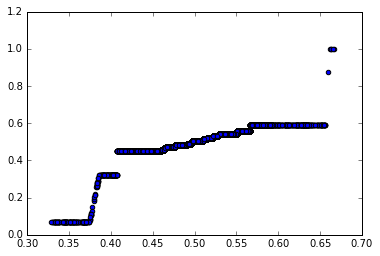

In [48]:
IS.fit(new_train_feature, train_y)
pred = IS.predict(new_test_feature)
plt.scatter(new_test_feature, pred)
plt.show()

In [31]:
LR.fit(new_train_feature.reshape(-1, 1), train_y)
pred = LR.predict_proba(new_test_feature.reshape(-1, 1))[:, 1]

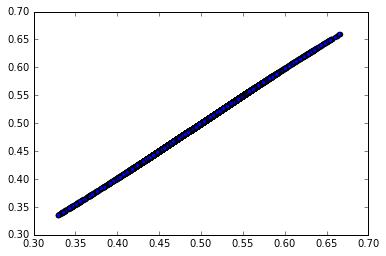

In [32]:
plt.scatter(new_test_feature, pred)
plt.show()

In [5]:
Linear.fit(new_train_feature.reshape(-1, 1), train_y)
pred = Linear.predict(new_test_feature.reshape(-1, 1))

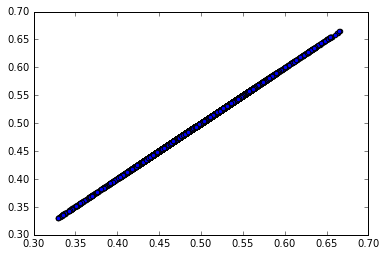

In [15]:
plt.scatter(new_test_feature, pred)
plt.show()

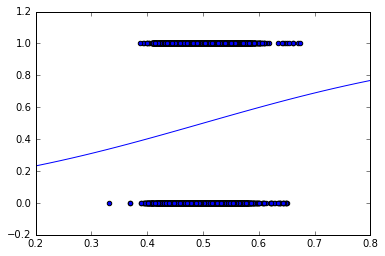

In [33]:
sample = np.random.choice(np.arange(len(train_y)), 100000)
plt.scatter(new_train_feature[sample], train_y[sample])
x = np.linspace(0, 1)
y = LR.predict_proba(x.reshape(-1, 1))[:, 1]
plt.plot(x, y)
plt.xlim(0.2, 0.8)
plt.show()

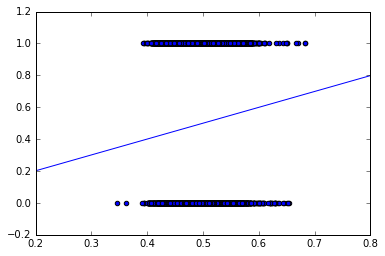

In [21]:
sample = np.random.choice(np.arange(len(train_y)), 100000)
plt.scatter(new_train_feature[sample], train_y[sample])
x = np.linspace(0, 1)
y = Linear.predict(x.reshape(-1, 1))
plt.plot(x, y)
plt.xlim(0.2, 0.8)
plt.show()

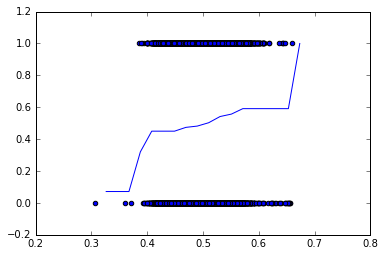

In [49]:
sample = np.random.choice(np.arange(len(train_y)), 100000)
plt.scatter(new_train_feature[sample], train_y[sample])
x = np.linspace(0, 1)
y = IS.predict(x)
plt.plot(x, y)
plt.xlim(0.2, 0.8)
plt.show()

In [60]:
# 線形回帰
sample_submission[1] = pred
sample_submission[1][sample_submission[1] > 0.8] = 0.8
sample_submission[1][sample_submission[1] < 0.1] = 0.1
sample_submission.to_csv("result.csv", index=0)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [61]:
sample_submission[1].min()

0.10000000000000001

In [62]:
sample_submission[1].max()

0.80000000000000004

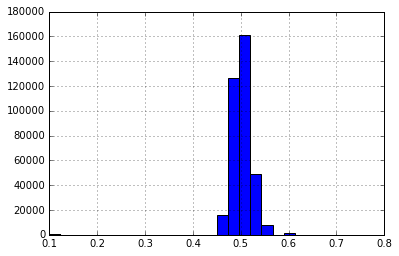

In [63]:
sample_submission[1].hist(bins=30)